In [24]:
%reset
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm, multivariate_normal
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D, get_test_data
from matplotlib import cm
import matplotlib.gridspec as gridspec

from ccm import ccm, extended_ccm

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
# Settings for plot
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["axes.titlesize"] = 20
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20

# Function for a coupled two-species nonlienar logistic difference system with chaotic dynamics
def two_species_logistic(x0, y0, N, rx, ry, bxy, byx):
    x = lambda x, y: x*(rx-rx*x-bxy*y)
    y = lambda x, y: y*(ry-ry*y-byx*x)

    x_set = np.zeros(N)
    y_set = np.zeros(N)
    x_set[0] = x0
    y_set[0] = y0
    
    for i in range(N-1):
        x_set[i+1] = x_set[i]*(rx-rx*x_set[i]-bxy*y_set[i])
        y_set[i+1] = y_set[i]*(ry-ry*y_set[i]-byx*x_set[i])
#         xnow, ynow = x_set[i], y_set[i]
#         x_set[i+1] = x(xnow, ynow)
#         y_set[i+1] = y(xnow, ynow)
    
    return x_set, y_set

In [26]:
### The change of correlation coefficients versus time lengths
# Parameter settings
rx, ry = 3.8, 3.1
bxy, byx = 0.0, .8
x0, y0 = .2, .4
L      = 2000
L_future = 1000
lag = 10
tau, E = 1, 2

# Simulation
x_set, y_set = two_species_logistic(x0, y0, L+L_future, rx, ry, bxy, byx)
if lag > 0:
    x,     y     = x_set[:L-lag], y_set[lag:L]
    x_future, y_future = x_set[L:-lag], y_set[lag+L:]
elif lag < 0:
    x,     y     = x_set[-lag:L], y_set[:L+lag]
    x_future, y_future = x_set[-lag+L:], y_set[L:lag]
else:
    x,     y     = x_set[:L], y_set[:L]
    x_future, y_future = x_set[L:], y_set[L:]
    
xmpy, rho1 = ccm(x, y, x_future, y_future, E, tau)
ympx, rho2 = ccm(y, x, y_future, x_future, E, tau)
print rho1, rho2

0.995859757347 0.294247020049


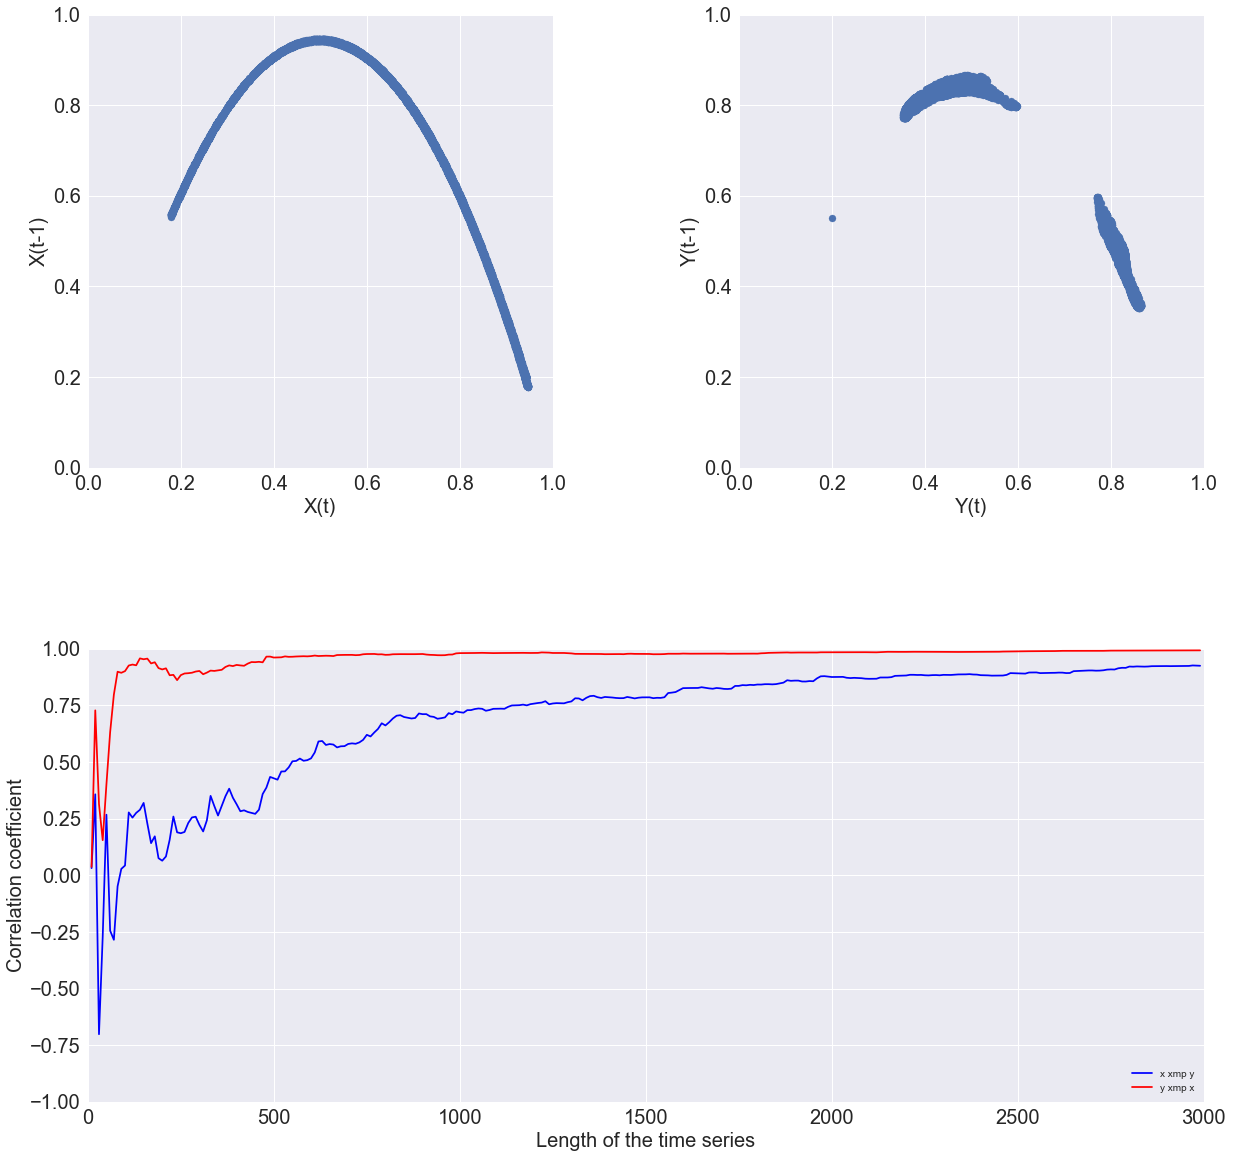

In [29]:
### The change of correlation coefficients versus time lengths
# Parameter settings
bxy, byx = .02, .1
rx, ry = 3.8, 3.5
x0, y0 = .4, .2
# x0 = .35 + .1*np.random.rand()
# y0 = .15 + .1 *np.random.rand()
L      = 3000
tau, E = 1, 2
L_set = range(10, L, 10)

# Compute rho for different lengths of the time series
xmpy, ympx = [], []
for l in L_set:
    # Simulation
    x_set, y_set = two_species_logistic(x0, y0, l+l, rx, ry, bxy, byx)
    x, y = x_set[:l], y_set[:l]
    x_future, y_future = x_set[l:], y_set[l:]
    _, rho1 = ccm(x, y, x_future, y_future, E, tau)
    _, rho2 = ccm(y, x, y_future, x_future, E, tau)
    xmpy.append(rho1)
    ympx.append(rho2)

# Plot
plt.rcParams["figure.figsize"] = (20,20)
gs = gridspec.GridSpec(2, 2)
gs.update(wspace=0.4, hspace=0.4)

ax = plt.subplot(gs[0, 0])
ax.scatter(x_set[:-1], x_set[1:])
ax.set_xlabel('X(t)')
ax.set_ylabel('X(t-1)')
ax.set_ylim([0, 1])
ax.set_xlim([0, 1])

ax = plt.subplot(gs[0, 1])
ax.scatter(y_set[:-1], y_set[1:])
ax.set_xlabel('Y(t)')
ax.set_ylabel('Y(t-1)')
ax.set_ylim([0, 1])
ax.set_xlim([0, 1])

ax = plt.subplot(gs[1, :])
ax.plot(L_set, xmpy, 'b', label='x xmp y')
ax.plot(L_set, ympx, 'r', label='y xmp x')
ax.set_xlabel('Length of the time series')
ax.set_ylabel('Correlation coefficient')
ax.set_ylim([-1, 1])
ax.set_xlim([0, L])
ax.legend(loc='lower right')

plt.show()

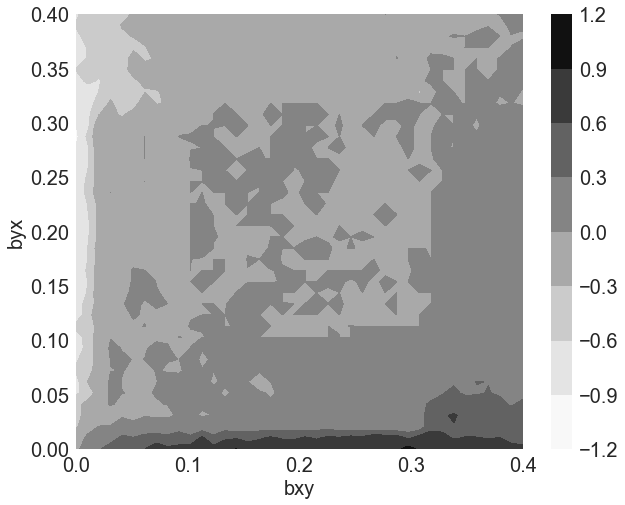

In [28]:
### The change of correlation coefficients in terms of different bxy and byx
# Parameter settings
bxy_set = np.linspace(0, .4, 40)
byx_set = np.linspace(0, .4, 40)
rx, ry  = 3.7, 3.7
L       = 400
L_future = 1000
n_bxy, n_byx = bxy_set.size, byx_set.size

xmpy = np.zeros([n_bxy, n_byx])
ympx = np.zeros([n_bxy, n_byx])

# CCM
for i in range(n_bxy):
    for j in range(n_byx):
        bxy, byx = bxy_set[i], byx_set[j]
        x_set, y_set = two_species_logistic(x0, y0, L+L_future, rx, ry, bxy, byx)
        x,     y     = x_set[:L], y_set[:L]
        x_future, y_future = x_set[L:], y_set[L:]
        _, rho1 = ccm(x, y, x_future, y_future, E, tau)
        _, rho2 = ccm(y, x, y_future, x_future ,E, tau)
        xmpy[i, j] = rho1
        ympx[i, j] = rho2

# Plot
plt.rcParams["figure.figsize"] = (10, 8)
xv, yv = np.meshgrid(bxy_set, byx_set, indexing='ij')

plt.contourf(xv, yv, xmpy-ympx)
plt.colorbar()
plt.xlabel('bxy')
plt.ylabel('byx')
plt.show()

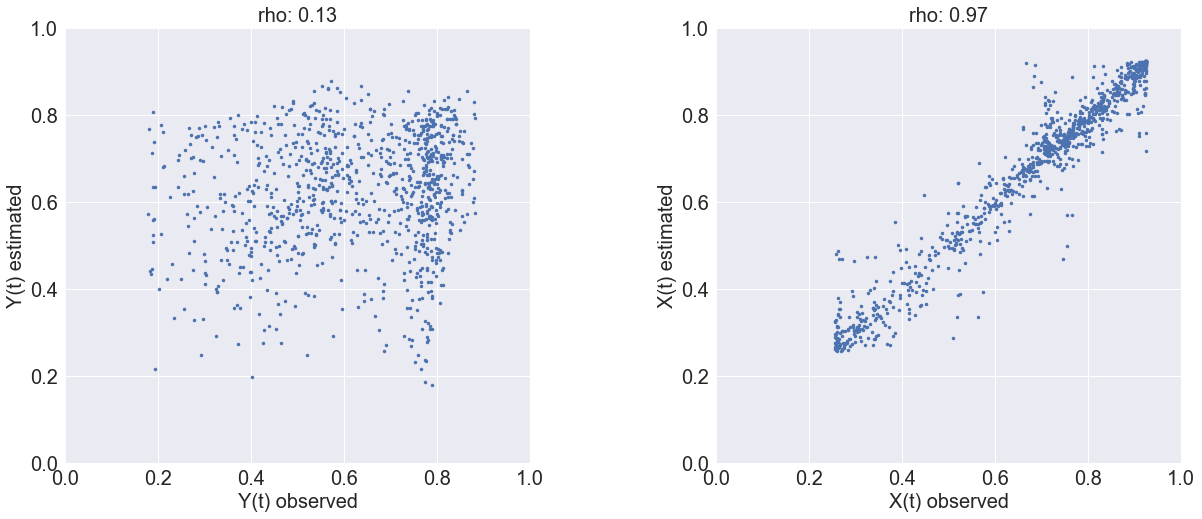

In [27]:
### when bxy =0
bxy, byx = 0, .32
rx, ry = 3.7, 3.7
x0, y0 = .2, .4
L = 1000
L_future = 1000
E, tau = 2, 1
x_set, y_set = two_species_logistic(x0, y0, L+L_future, rx, ry, bxy, byx)
x,     y     = x_set[:L], y_set[:L]
x_future, y_future = x_set[L:], y_set[L:]
y_est, rho1 = ccm(x, y, x_future, y_future, E, tau)
x_est, rho2 = ccm(y, x, y_future, x_future, E, tau)

# Plot
plt.rcParams["figure.figsize"] = (20, 8)

gs = gridspec.GridSpec(1, 2)
gs.update(wspace=0.4, hspace=0.4)

ax = plt.subplot(gs[0, 0])
ax.plot(y_future[tau*(E-1):], y_est, '.')
ax.set_xlabel('Y(t) observed')
ax.set_ylabel('Y(t) estimated')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_title('rho: %.2f' % rho1)

ax = plt.subplot(gs[0, 1])
ax.plot(x_future[tau*(E-1):], x_est, '.')
ax.set_xlabel('X(t) observed')
ax.set_ylabel('X(t) estimated')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_title('rho: %.2f' % rho2)

plt.show()

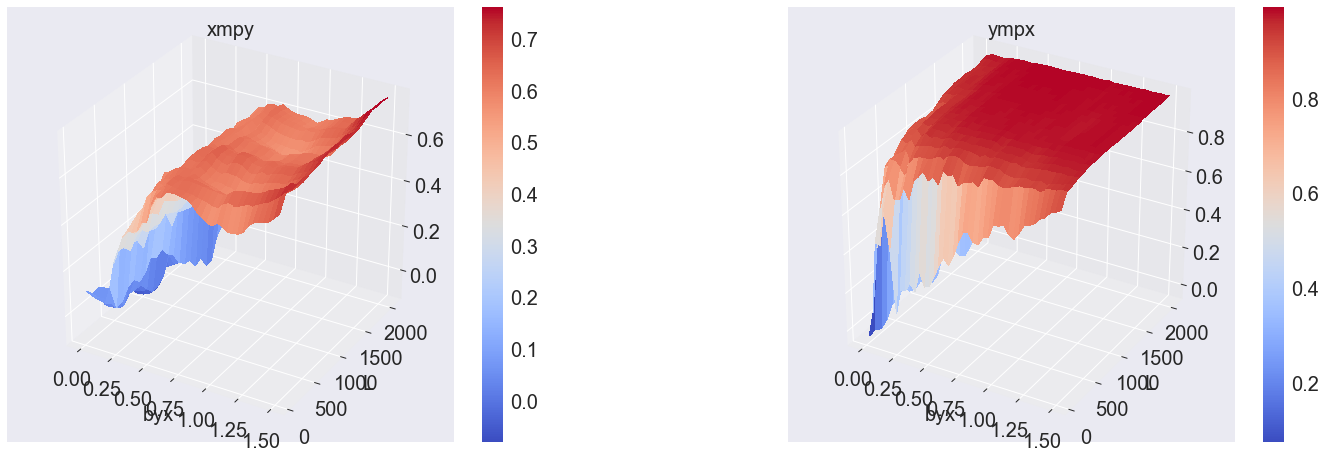

In [232]:
### when bxy =0
rx, ry = 3.8, 3.5
x0, y0 = .4, .2
tau, E = 1, 2
L_set = np.arange(50, 2100, 100)
L_future = 1000
byx_set = np.linspace(0, 1.5, 40)
bxy = 0

xmpy = np.zeros([byx_set.size, L_set.size])
ympx = np.zeros([byx_set.size, L_set.size])

for j in range(L_set.size):
    for i in range(byx_set.size):
        byx, L = byx_set[i], L_set[j]
        x_set, y_set = two_species_logistic(x0, y0, L+L_future, rx, ry, bxy, byx)
        x,     y     = x_set[:L], y_set[:L]
        x_future, y_future = x_set[L:], y_set[L:]
        _, rho1 = ccm(x, y, x_future, y_future, E, tau)
        _, rho2 = ccm(y, x, y_future, x_future, E, tau)
        xmpy[i, j] = rho1
        ympx[i, j] = rho2

# Plot
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
# ax = fig.add_subplot(111, projection='3d')
plt.rcParams["figure.figsize"] = (24, 8)
xv, yv = np.meshgrid(byx_set, L_set, indexing='ij')

gs = gridspec.GridSpec(1, 2)
gs.update(wspace=0.4, hspace=0.4)

ax = plt.subplot(gs[0, 0], projection='3d')
cs = ax.plot_surface(xv, yv, xmpy,cmap=cm.coolwarm,
                     linewidth=0, antialiased=False)
plt.colorbar(cs, ax=ax)
ax.set_xlabel('byx')
ax.set_ylabel('L')
ax.set_title('xmpy')

ax = plt.subplot(gs[0, 1], projection='3d')
cs = ax.plot_surface(xv, yv, ympx,cmap=cm.coolwarm,
                     linewidth=0, antialiased=False)
plt.colorbar(cs, ax=ax)
ax.set_xlabel('byx')
ax.set_ylabel('L')
ax.set_title('ympx')

plt.show()

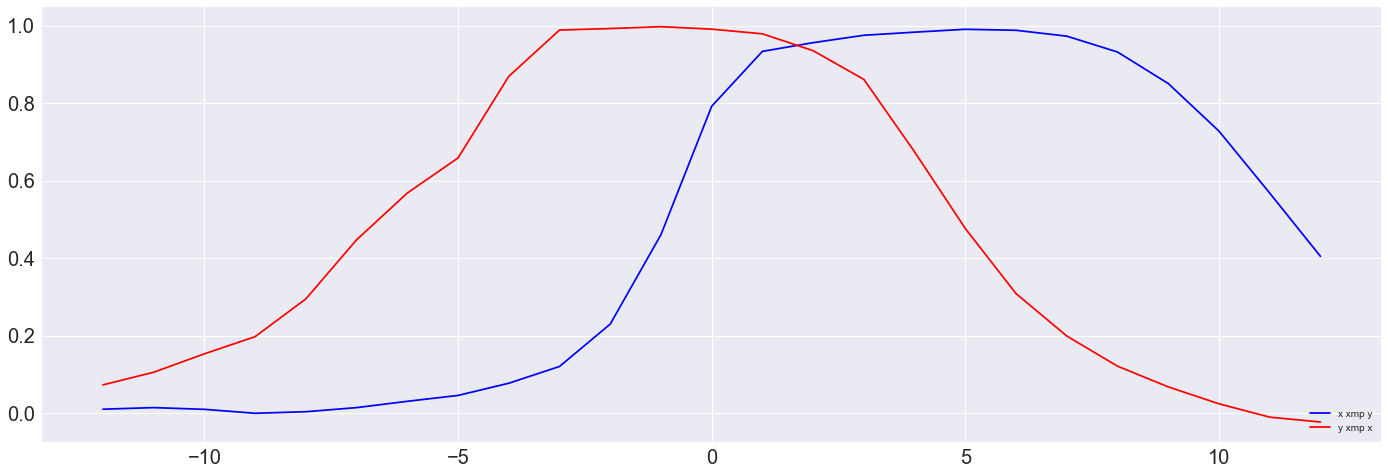

-1 5


In [30]:
### Extended CCM
# Parameter settings
lagmax = 12
rx, ry = 3.8, 3.1
bxy, byx = 0.0, .8
x0, y0 = .2, .4
L = 2000
L_future = 1000
E, tau = 2, 1
nsample = 30

# Simulate the model
x_set, y_set = two_species_logistic(x0, y0, L+L_future, rx, ry, bxy, byx)
x, y = x_set[200:2000], y_set[200:2000]
x_future, y_future = x_set[L:], y_set[L:]
randint = np.random.randint(200, 1500, nsample)

# Conduct the extended CCM
rhoxmpy_m, rhoympx_m = 0., 0.
for i in range(nsample):
    rint = randint[i]
    x, y = x_set[rint:rint+200], y_set[rint:rint+200]
    lagset, rhoxmpy, rhoympx = extended_ccm(x, y, x_future, y_future, E, lagmax, tau)
    rhoxmpy_m += rhoxmpy
    rhoympx_m += rhoympx

rhoxmpy_m = rhoxmpy_m / nsample
rhoympx_m = rhoympx_m / nsample

# Plot
# ax = fig.add_subplot(111, projection='3d')
plt.rcParams["figure.figsize"] = (24, 8)

plt.plot(lagset, rhoxmpy_m, 'b', label='x xmp y')
plt.plot(lagset, rhoympx_m, 'r', label='y xmp x')
plt.legend(loc='lower right')
plt.show()

print lagset[np.argmax(rhoympx_m)], lagset[np.argmax(rhoxmpy_m)]

In [220]:
bxy, byx = .02, .1
rx, ry = 3.8, 3.5
x0, y0 = .4, .2
# x0 = .35 + .1*np.random.rand()
# y0 = .15 + .1 *np.random.rand()
L      = 500
tau, E = 1, 2
L_set = range(10, L, 10)

# Compute rho for different lengths of the time series
i = 0
# Simulation
l = L_set[0]
x_set, y_set = two_species_logistic(x0, y0, l+l, rx, ry, bxy, byx)
x, y = x_set[:l], y_set[:l]
x_future, y_future = x_set[l:], y_set[l:]
yest, rho1 = ccm(x, y, x_future, y_future, E, tau)
xest, rho2 = ccm(y, x, y_future, x_future, E, tau)
print rho1, rho2

0.147235504405 -0.0344610146375


5 -1
